## Pulse Overlay + Measured FROG Traces

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


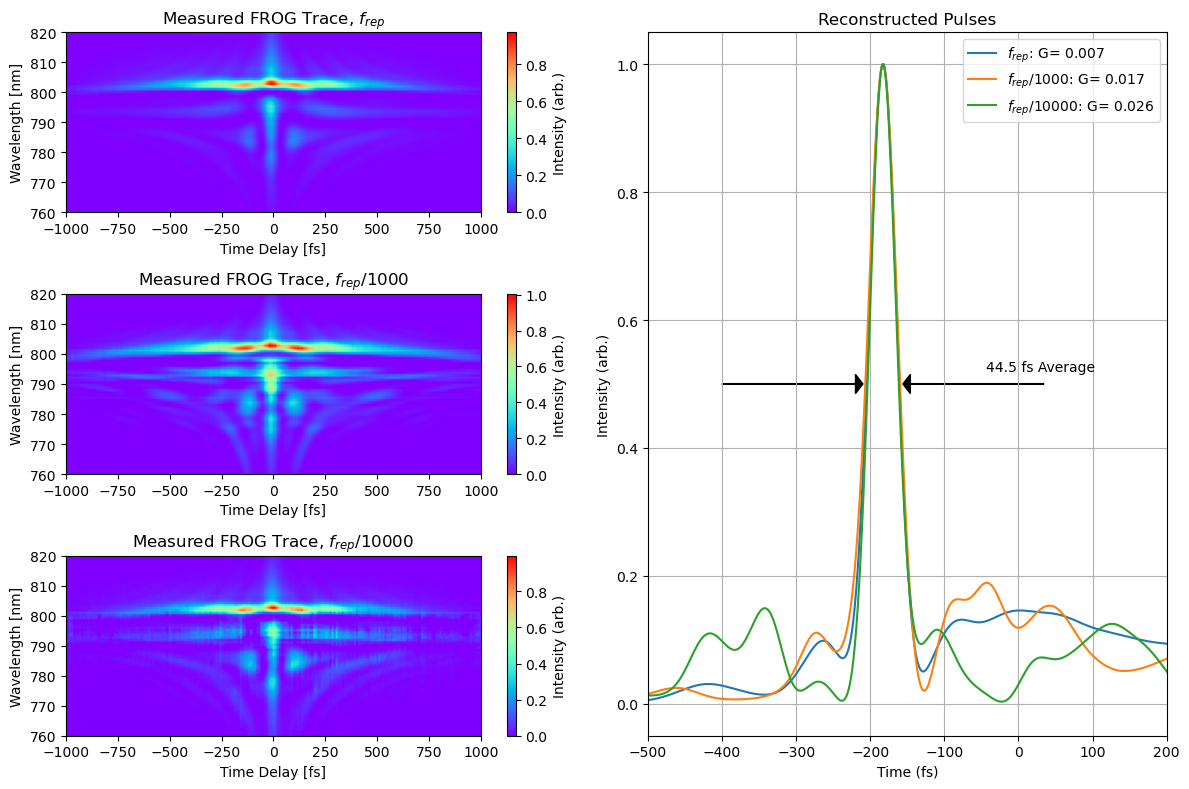

In [57]:
import matplotlib.pyplot as plt
from utils import frogdata
from pathlib import Path
import re

# File management
frog_path = Path(
    r'C:\Users\wahlm\Documents\School\Research\Allison\Tunable Pump\Data for Papers\Tunable seed\FROGs vs. pulse pattern\Low rep rate')
savepath = Path(r'C:\Users\wahlm\Documents\School\Research\Allison\Papers\tunable-pump-seed') / 'rep_rate_vs_pulse_slow_axis.eps'
pattern = r'.*'
sort = lambda frog: 0 if re.search(r'\d+', frog.label) is None else int(re.search(r'\d+', frog.label)[0])
label = lambda name: r'$f_{rep}$' if re.search(r'\d+', frog.label) is None else r'$f_{rep}/$' + (re.search(r'\d+', name)[0])
save_files = True

# Plotting options
panels = [['Trace 0', 'Pulses'],
          ['Trace 1', 'Pulses'],
          ['Trace 2', 'Pulses']]
cmap = 'rainbow'
f, ax = plt.subplot_mosaic(mosaic=panels, figsize=(12,8))

ax['Pulses'].set_xlabel('Time (fs)')
ax['Pulses'].set_ylabel('Intensity (arb.)')
ax['Pulses'].set_title('Reconstructed Pulses')
ax['Pulses'].set_xlim([-500, 200])

for i in range(3):
    ax[f'Trace {i}'].set_ylim([760, 820])
    ax[f'Trace {i}'].set_xlim([-1000, 1000])
    ax[f'Trace {i}'].set_xlabel('Time Delay [fs]')
    ax[f'Trace {i}'].set_ylabel('Wavelength [nm]')

    
fullscreen = False

# Do the thing
frogs = frogdata.read_frog_directory(frog_path, pattern=pattern)
frogs = sorted(frogs, key=sort)
frogs = [frogs[0], frogs[4], frogs[5]]
avg_duration = sum([frog.t_FWHM for frog in frogs ])/len(frogs)
for i, frog in enumerate(frogs):
    # Fix the phase signs to all be the same (pulse maximum on the left of the plot)
    if frog.pulse_time[frog.pulse_intensity == max(frog.pulse_intensity)] > frog.pulse_time[
                                                                int(len(frog.pulse_time) / 2)]:
        frog.pulse_intensity = frog.pulse_intensity[::-1]

    # Have all the maxima overlap one another in time
    frog.pulse_time = frog.pulse_time - (frog.pulse_time[frog.pulse_intensity == max(frog.pulse_intensity)] -
                                            frogs[0].pulse_time[frogs[0].pulse_intensity == max(frogs[0].pulse_intensity)])

    # Plot the pulse
    
    # Plot the trace
    map = ax[f'Trace {i}'].imshow(frog.trace, aspect='auto', extent=[min(frog.delays), max(frog.delays), min(frog.wavelengths),
                                                      max(frog.wavelengths)], cmap=cmap)
    plt.colorbar(map, label='Intensity (arb.)')
    ax['Pulses'].plot(frog.pulse_time, frog.pulse_intensity, label=f'{label(frog.label)}: G={frog.frog_error: .3f}')
    ax[f'Trace {i}'].set_title(f'Measured FROG Trace, {label(frog.label)}')

ax['Pulses'].legend()  
ax['Pulses'].grid()  
ax['Pulses'].arrow(-400, .5, 190, 0, color='k', length_includes_head=True, head_width=.03, head_length=10)
ax['Pulses'].arrow(34, .5, -190, 0, color='k', length_includes_head=True, head_width=.03, head_length=10)
ax['Pulses'].annotate(f'{avg_duration:.1f} fs Average', (-44, .52))

if fullscreen:
    f.canvas.manager.window.showMaximized()  # toggle fullscreen mode
plt.tight_layout()
if save_files:
    plt.savefig(savepath, dpi=500)
plt.show()


## Spectra by Pulse Pattern

c:\Users\wahlm\Documents\School\Research\Allison\Codes\Dev-table\Plotting\utils\spectrometerdata.py:204: RuntimeWarning: divide by zero encountered in log10
  self._y_axis_data = 10 * np.log10(linear_y_data * self.total_power_mW / integral / delta_x)


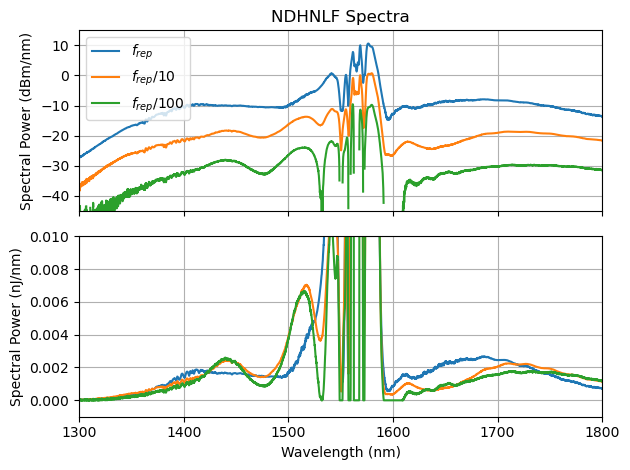

In [5]:
# Plots every spectrum in a user-selected folder. Works for the Yokogawa spectrometer.
import matplotlib.pyplot as plt
from utils.spectrometerdata import OSAData, readFromFiles
from pathlib import Path


c_nm_ps = 299792.458


directorypath = Path(
    r'C:\Users\wahlm\Documents\School\Research\Allison\Tunable Pump\Pulse Optimization and Spectrum Generation\10-5-23 Optimized 4cm ND spectra\42cm\Post pulser optimization')
savepath = Path(r'C:\Users\wahlm\Documents\School\Research\presentations\October-2023-group-meeting'
                r'\figures') / 'spectra_by_rep_rate.eps'
save_files = False

raw_data = readFromFiles(directorypath)
labels = (r'$f_{rep}$',
            r'$f_{rep}/10$',
            r'$f_{rep}/100$',
            'background'
            )
frep_frac = [1, 1/10, 1/100, 0]
is_background = (False, False, False, True)   
powers_mW = [191, 33, 15.37, 13.9]

data = [OSAData(dat, ('nm', 'dBm/nm'), labels[i], powers_mW[i], frep_MHz=frep_frac[i] * 60.56, is_background=is_background[i]) for i, dat in enumerate(raw_data)]
# data = data[:-1]
# Background subtraction
for datum in data:
    datum.y_axis_units = 'mW/nm'
for i, datum in enumerate(data[:-1]):
    datum.y_axis_data = datum.y_axis_data - (1 - frep_frac[i]) * data[-1].y_axis_data
    datum.total_power_mW = datum.total_power_mW - (1 - frep_frac[i]) * data[-1].total_power_mW 

data = data[:-1]   
    
fig, axs = plt.subplots(2, 1, sharex=True)

for datum in data:
    datum.y_axis_units = 'dBm/nm'
    axs[0].plot(datum.x_axis_data, datum.y_axis_data, label=datum.label)
# axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_ylabel(f'Spectral Power ({data[0].y_axis_units})')
axs[0].legend()
axs[0].set_title('NDHNLF Spectra')
axs[0].grid()


for datum in data:
    datum.y_axis_units = 'nJ/nm'

    axs[1].plot(datum.x_axis_data, datum.y_axis_data, label=datum.label)
axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_ylabel(f'Spectral Power ({data[0].y_axis_units})')
axs[1].grid()



for ax in axs.flatten():
    ax.set_xlim([1300, 1800])

axs[0].set_ylim([-45, 15])
axs[1].set_ylim([-.001, .01])
# axs[1].set_ylim([-45, 10])


# fig.canvas.manager.window.showMaximized()  # toggle fullscreen mode
plt.tight_layout()
if save_files:
    plt.savefig(savepath, dpi=500)
plt.show()


## Pulses 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


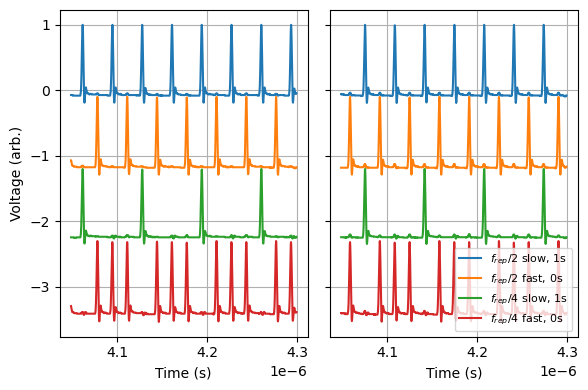

In [12]:
# Plots every scope lineout in user-selected folder. Works for Tektronix scopes
from pathlib import Path
import matplotlib.pyplot as plt
from utils.plotting_utils import directory_to_dataframes, get_scope_data, normalize_by_maximum

# File save parameters
save_fig = True
savepath = Path(r'C:\Users\wahlm\Documents\School\Research\Allison\Papers\tunable-pump-seed') /'polarization_scope_traces.eps'

# Data extraction
directorypath_pre = Path(r'C:\Users\wahlm\Documents\School\Research\Allison\Tunable Pump\Data for Papers\Tunable seed\Pulse traces and rf spectra\Pre-EDFA')
dfs_pre = directory_to_dataframes(directorypath_pre)
labels_pre = {
            r'$f_{rep}$/2 slow, 1s':0,
            r'$f_{rep}$/4 slow, 1s':2,
            r'$f_{rep}$/2 fast, 0s':1,
            r'$f_{rep}$/4 fast, 0s':3,
            r'$f_{rep}$/2 fast, 1s':4,
            r'$f_{rep}$/4 fast, 1s':6,
            r'$f_{rep}$/2 slow, 0s':5,
            r'$f_{rep}$/4 slow, 0s':7
            }
data_pre = get_scope_data(dfs_pre, list(labels_pre.keys()))
normalize_by_maximum(data_pre, 'voltage_V')

directorypath_post = Path(r'C:\Users\wahlm\Documents\School\Research\Allison\Tunable Pump\Data for Papers\Tunable seed\Pulse traces and rf spectra\Post-EDFA')
dfs_post = directory_to_dataframes(directorypath_post)
labels_post = {
            r'$f_{rep}$/2 slow, 1s':0,
            r'$f_{rep}$/4 slow, 1s':2,
            r'$f_{rep}$/2 fast, 0s':1,
            r'$f_{rep}$/4 fast, 0s':3,
            r'$f_{rep}$/2 fast, 1s':4,
            r'$f_{rep}$/4 fast, 1s':6,
            r'$f_{rep}$/2 slow, 0s':5,
            r'$f_{rep}$/4 slow, 0s':7
            }
data_post = get_scope_data(dfs_post, list(labels_post.keys()))
normalize_by_maximum(data_post, 'voltage_V')

# Create a figure and axis object using matplotlib
fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharey=True)

for i, tup in enumerate(sorted(data_pre.items(), key=lambda x: labels_pre[x[0]])):
    if i < 4:
        ax[0].plot(tup[1]['time_s'], tup[1]['voltage_V'] - i * 1.1, label=tup[0])
# Add axis labels and a legend
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Voltage (arb.)')
ax[0].grid()

for i, tup in enumerate(sorted(data_post.items(), key=lambda x: labels_post[x[0]])):
    if i < 4:
        ax[1].plot(tup[1]['time_s'], tup[1]['voltage_V'] - i * 1.1, label=tup[0])
# Add axis labels and a legend
ax[1].set_xlabel('Time (s)')
# ax[1].legend(fontsize=8)
ax[1].grid()

# Display the plot
plt.tight_layout()
if save_fig:
    fig.savefig(savepath, dpi=300)
plt.show()
